In [12]:
import perceval as pcvl
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from perceval.algorithm import Sampler
from tqdm import tqdm
from perceval.components.unitary_components import PS, BS, PERM

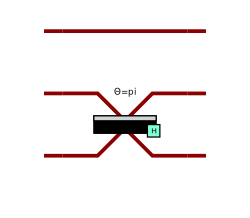

In [13]:
def initialize_processor(old_result=None, new_data_normalized=np.array([0.5]), num_ancillas=1, N=None):
    """
    Parameters
    ----------
    old_result : list of int
        The result of the previous iteration. If None, then N must be specified.
    new_data_normalized : np.array
        The new data, normalized to [0, 1].
    num_ancillas : int
        The number of ancillas to use.
    N : int
        The number of data points if old_result is None.
    
    Returns
    -------
    processor : Processor
        The processor that prepares the state.
    """
    
    
    assert num_ancillas == np.atleast_1d(new_data_normalized).shape[0]
    assert np.all(0 <= new_data_normalized <= 1)
    if old_result is None:
        assert N is not None
        old_result = [1 for _ in range(N)]
    
    new_data_normalized = np.atleast_1d(new_data_normalized)
    processor = pcvl.Processor("SLOS", len(old_result) + 2*num_ancillas)
    processor.with_input(pcvl.BasicState(old_result + num_ancillas*[1, 0]))
    for i in range(num_ancillas):
        processor.add(len(old_result) + 2*i, BS.H(theta=np.pi*new_data_normalized[i]))
    return processor

p = initialize_processor([2], 1, 1)
pcvl.pdisplay(p)

In [14]:
def initialize_circuit(old_result=None, new_data_normalized=np.array([0.5]), num_ancillas=1, N=None):
    """
    Parameters
    ----------
    old_result : list of int
        The result of the previous iteration. If None, then N must be specified.
    new_data_normalized : np.array
        The new data, normalized to [0, 1].
    num_ancillas : int
        The number of ancillas to use.
    N : int
        The number of data points if old_result is None.
    
    Returns
    -------
    processor : Processor
        The processor that prepares the state.
    """
    
    assert num_ancillas == np.atleast_1d(new_data_normalized).shape[0]
    assert np.all(0 <= new_data_normalized <= 1)
    if old_result is None:
        assert N is not None
        old_result = [1 for _ in range(N)]
    
    new_data_normalized = np.atleast_1d(new_data_normalized)
    circuit = pcvl.Circuit(len(old_result) + 2*num_ancillas)
    backend = pcvl.BackendFactory.get_backend("SLOS")
    backend.set_circuit(circuit)
    backend.set_input_state(old_result)
    prob_distribution = backend.prob_distribution()

    expectations = [0.0 for _ in range(modes)]
    for state, probability in prob_distribution.items():
        for mode in range(modes):
            expectations[mode] += state[mode] * probability
    return expectations
    processor.with_input(pcvl.BasicState(old_result + num_ancillas*[1, 0]))
    for i in range(num_ancillas):
        processor.add(len(old_result) + 2*i, BS.H(theta=np.pi*new_data_normalized[i]))
    return processor

p = initialize_processor([2], 1, 1)
pcvl.pdisplay(p)

circuit = pcvl.Circuit(3)
circuit.add(0, BS(pcvl.P("theta_1"))) 
circuit.add(1, BS(pcvl.P("theta_2")))
circuit.get_parameters()

[Parameter(name='theta_1', value=None, min_v=0.0, max_v=12.566370614359172),
 Parameter(name='theta_2', value=None, min_v=0.0, max_v=12.566370614359172)]

In [15]:
def U_ij_t(i : int , j : int, t : int = 0):
    """Returns the unitary acting on mode i and j."""
    return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
            .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

In [16]:
def filter_keys_with_sum_one(dictionary):
    """
    Filter the keys in the dictionary where the sum of the last two numbers in the key string is exactly 1.

    :param dictionary: Dictionary with keys in a specific string format and numerical values.
    :return: List of keys that satisfy the condition.
    """
    filtered_keys = {}

    for key in dictionary.keys():
        # Split the key string and convert to integers
        numbers = [int(num) for num in list(key)]

        # Check if the sum of the last two numbers is 1
        if sum(numbers[-2:]) == 1:
            filtered_keys[key] = dictionary[key]

    return filtered_keys

In [17]:
def set_circuit_parameters(circuit, parameter_matrix):
    """Set the parameters of the circuit to the values in the matrix.

    Args:
        parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

    Description:
        The parameter matrix is flattened to match the list of parameters.
        The parameters are set in the order they appear in the circuit.
    """
    flattened_params = parameter_matrix.flatten()
    params = circuit.get_parameters()
    assert len(params) == len(
        flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
    for param, value in zip(params, flattened_params):
        param.set_value(value)

In [18]:
def set_processor_parameters(processor, parameter_matrix):
    """Set the parameters of the processor to the values in the matrix.

    Args:
        processor (Processor): The processor to set the parameters for.
        parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

    Description:
        The parameter matrix is flattened to match the list of parameters.
        The parameters are set in the order they appear in the circuit.
    """
    flattened_params = parameter_matrix.flatten()
    params = list(processor.get_circuit_parameters().values())
    assert len(params) == len(
        flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
    for param, value in zip(params, flattened_params):
        param.set_value(value)

# Data

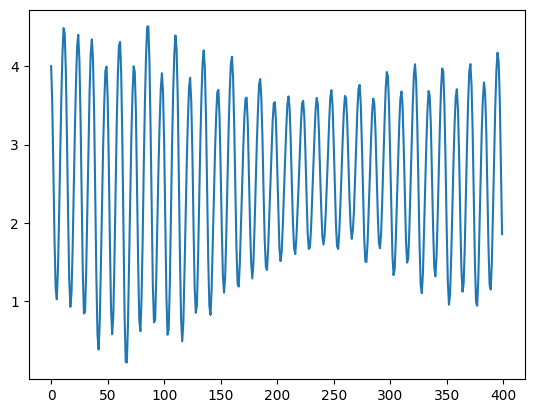

In [19]:
data = pd.read_csv("IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv")
data = data["Water_Level_LAT"].drop(0).astype(float)
data = data.groupby(data.index // 12).mean()[:400]
plt.plot(data.index, data.values)

### Old version with circuit

In [20]:
n=5
num_ancillas = 1
init_state = [1,1,1,1,1] + [1,0]
data_renormalized = (data - min(data))/(max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()
expectation_matrix = np.zeros((len(data), n))

for i, level in enumerate(data_renormalized):
    if i % 10 == 0:
        print(i)
    circuit = pcvl.Circuit(n + 2*num_ancillas)
    # ancilla data initialization
    circuit.add(n, BS.H(theta=2*np.pi*level))
    
    # add circuit beam splitters and connector to ancilla
    for j in range(n-1, -1, -1):
        circuit.add(j, pcvl.BS(pcvl.P(f"theta_{j}")))
        # circuit.add(j, pcvl.BS())
    parameter_matrix = np.array([level * 2 * np.pi] * n)
    set_circuit_parameters(circuit, parameter_matrix)
    backend = pcvl.BackendFactory.get_backend("SLOS")
    backend.set_circuit(circuit)
    backend.set_input_state(pcvl.BasicState(init_state))
    prob_distribution = backend.prob_distribution()
    prob_distribution = filter_keys_with_sum_one(prob_distribution)
    expectations = [0.0 for _ in range(n)]
    for state, probability in prob_distribution.items():
        for mode in range(n):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations
    init_state = list(max(prob_distribution, key=prob_distribution.get))[:n] + [1,0]
pcvl.pdisplay(circuit, recursive=True)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370


KeyboardInterrupt: 

### Maurice variant

In [ ]:
n=5
num_ancillas = 1
init_state = [1,1,1,1,1] + [1,0]
data_renormalized = (data - min(data))/(max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()
expectation_matrix = np.zeros((len(data),n))
for i, level in enumerate(data_renormalized):
    if i % 10 == 0:
        print(i)
    circuit = pcvl.Circuit(n + 2*num_ancillas)
    for k in range(i+1):
        for j in range(n-1, -1, -1):
            circuit.add(j, U_ij_t(j, j+1, k))
            # circuit.add(j, pcvl.BS())
    parameter_matrix = np.random.normal(level, 0.2, (n,n*(i+1))) * 2 * np.pi
    set_circuit_parameters(circuit, parameter_matrix)
    backend = pcvl.BackendFactory.get_backend("SLOS")
    backend.set_circuit(circuit)
    backend.set_input_state(pcvl.BasicState(init_state))
    prob_distribution = backend.prob_distribution()
    prob_distribution = filter_keys_with_sum_one(prob_distribution)
    expectations = [0.0 for _ in range(n)]
    for state, probability in prob_distribution.items():
        for mode in range(n):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


### New version - with processor

In [ ]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_STATE = [1, 0, 1, 0, 1] + [1, 0]
E_PROBABILITY = 0.7
MULTIPHOTON_COMPONENT = 0.1
SCALE = 0.2

# Normalize data
data_renormalized = (data - min(data)) / (max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()

# Initialize expectation matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))

# Main loop for circuit construction and simulation
for i, level in enumerate(data_renormalized):
    if i % 10 == 0:
        print(f"Processing data point {i}")

    # Initialize circuit with N_MODES + 2 * NUM_ANCILLAS
    circuit = pcvl.Circuit(N_MODES + 2 * NUM_ANCILLAS)

    # Ancilla data initialization
    circuit.add(N_MODES, pcvl.BS(theta=2 * np.pi * level))

    # Add circuit beam splitters and connector to ancilla
    for j in range(N_MODES - 1, -1, -1):
        circuit.add(j, pcvl.BS(pcvl.P(f"theta_{j}")))

    # Generate parameter matrix for circuit parameters
    parameter_matrix = np.array([np.random.normal(loc=level, scale=SCALE) * 2 * np.pi for _ in range(N_MODES)])
    set_circuit_parameters(circuit, parameter_matrix)

    # Set up processor and source for the circuit
    source = pcvl.Source(emission_probability=E_PROBABILITY, multiphoton_component=MULTIPHOTON_COMPONENT)
    processor = pcvl.Processor("SLOS", circuit, source)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']
    prob_distribution = filter_keys_with_sum_one(prob_distribution)

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i] = expectations

    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [1, 0]

# Display the final circuit
pcvl.pdisplay(circuit, recursive=True)

Processing data point 0
Processing data point 10
Processing data point 20
Processing data point 30
Processing data point 40
Processing data point 50
Processing data point 60
Processing data point 70


KeyboardInterrupt: 

### Circuit with randomly sampled beamsplitters

In [21]:
def random_indices_with_repeats(list_size, sample_size):
    """
    Generates a list of random indices with possible repeats, based on the given list size and sample size.
    Parameters:
    list_size (int): The size of the list from which indices are to be sampled.
    sample_size (int): The number of indices to sample, with possible repeats.
    Returns:
    list: A list of random indices, possibly with repeats.
    """
    # Generate a list of random indices, allowing repeats
    random_indices = random.choices(range(list_size), k=sample_size)
    return random_indices

# Example usage
list_size = 7  # Size of the list
sample_size = 10  # Number of indices to sample
sampled_indices = random_indices_with_repeats(list_size, sample_size)
print(sampled_indices)

[5, 0, 5, 6, 6, 0, 2, 1, 0, 5]


[3, 2, 1, 0, 1, 3, 2, 1, 3, 0, 2, 3]
[4.61599671 3.78781396 5.02430704 3.70715919 5.58008795 4.27423854
 5.42487801 1.33421951 5.04711585 4.5569459  5.57077603 0.76865963]
{'theta_0': Parameter(name='theta_0', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_1': Parameter(name='theta_1', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_2': Parameter(name='theta_2', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_3': Parameter(name='theta_3', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_4': Parameter(name='theta_4', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_5': Parameter(name='theta_5', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_6': Parameter(name='theta_6', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_7': Parameter(name='theta_7', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_8': Parameter(name='theta_8', value=None, min_v=0.0, max_v=12.566370614359172), 'theta_9': Parameter(name='theta_9', value=N

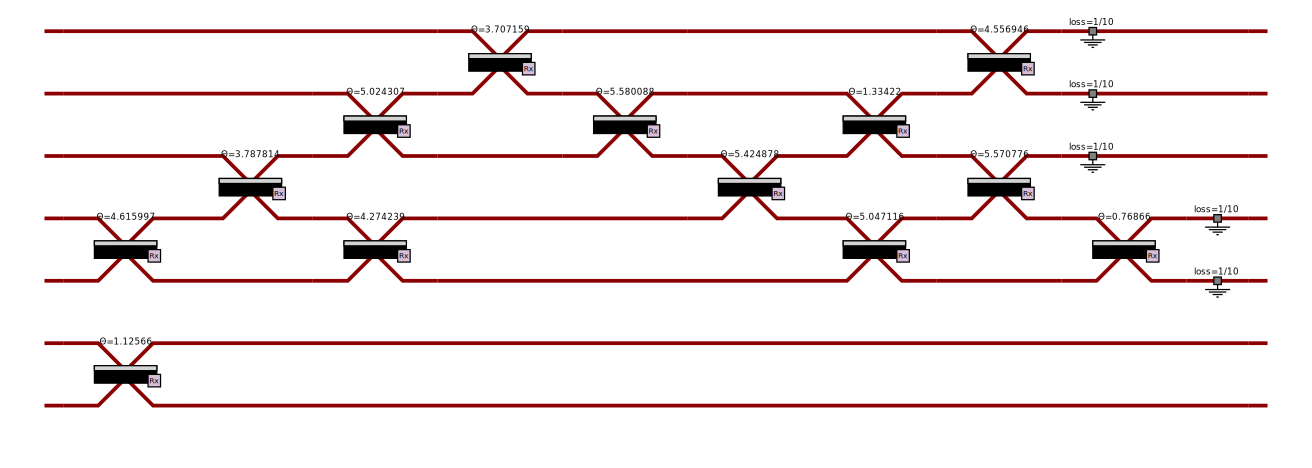

In [22]:
BS_INDEX = [3,2,1,0] + random_indices_with_repeats(N_MODES-1, 2*(N_MODES-1))
print(BS_INDEX)
parameter_matrix = np.random.rand(len(BS_INDEX)) * 2 * np.pi

print(parameter_matrix)
processor = pcvl.Processor("SLOS", N_MODES + 2 * NUM_ANCILLAS)
# Add circuit beam splitters and connector to ancilla
processor.add(N_MODES, pcvl.BS(theta=2 * np.pi * data_renormalized[i]))
# add BS cascade to ensure full connectivity and add random BS
for j, index in enumerate(BS_INDEX):
    processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))
# add loss channel to each mode
for i in range(N_MODES):
    processor.add(i, pcvl.LC(0.10))
print(processor.get_circuit_parameters())
set_processor_parameters(processor, parameter_matrix)
pcvl.pdisplay(processor)

Init state for new run [0, 0, 0, 0, 0, 2]
Beamsplitter arrangement [3, 2, 1, 0]


Computing layer:   3%|▎         | 11/400 [00:00<00:03, 108.26it/s]

Angle 5.5423940035633
Prob for upper 0.8689673805610676
Most probable state: |2,0,0,0,0,0>
Init state for new run [2, 0, 0, 0, 0, 2]
Angle 4.842291614591884
Prob for upper 0.5647687988977389
Most probable state: |1,2,0,0,0,1>
Init state for new run [1, 2, 0, 0, 0, 2]
Angle 3.570369017627076
Prob for upper 0.04526241641852091
Most probable state: |0,1,2,0,0,2>
Init state for new run [0, 1, 2, 0, 0, 2]
Angle 2.2804993461994303
Prob for upper 0.1741957382408546
Most probable state: |0,0,1,2,0,2>
Init state for new run [0, 0, 1, 2, 0, 2]
Angle 1.3875408249668892
Prob for upper 0.5911157620027976
Most probable state: |1,0,0,1,2,1>
Init state for new run [1, 0, 0, 1, 2, 2]
Angle 1.1810884241733115
Prob for upper 0.6899591176981711
Most probable state: |0,1,0,0,1,4>
Init state for new run [0, 1, 0, 0, 1, 2]
Angle 1.7196227470003198
Prob for upper 0.42586118596416817
Most probable state: |0,0,1,0,0,3>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 2.7041479746759025
Prob for upper 0.047081439

Computing layer:   6%|▌         | 22/400 [00:01<00:34, 11.06it/s] 

Most probable state: |0,2,0,2,2,4>
Init state for new run [0, 2, 0, 2, 2, 2]
Angle 1.0399536073091038
Prob for upper 0.7531301329703708
Most probable state: |0,0,2,0,2,4>
Init state for new run [0, 0, 2, 0, 2, 2]
Angle 1.2932881618015186
Prob for upper 0.6369800007394338
Most probable state: |0,0,0,2,0,4>
Init state for new run [0, 0, 0, 2, 0, 2]
Angle 2.108353938086512
Prob for upper 0.24398019886997185
Most probable state: |0,0,0,0,2,2>
Init state for new run [0, 0, 0, 0, 2, 2]
Angle 3.1936025428494403
Prob for upper 0.0006761047177026439
Most probable state: |2,0,0,0,0,2>
Init state for new run [2, 0, 0, 0, 0, 2]
Angle 4.335500416665131
Prob for upper 0.31598540110501533
Most probable state: |0,2,0,0,0,2>
Init state for new run [0, 2, 0, 0, 0, 2]
Angle 5.252388370514787
Prob for upper 0.7570677342811535
Most probable state: |1,0,2,0,0,1>
Init state for new run [1, 0, 2, 0, 0, 2]
Angle 5.920336971781294
Prob for upper 0.9674448166982237
Most probable state: |2,1,0,2,0,0>
Init state f

Computing layer:   7%|▋         | 27/400 [00:02<00:32, 11.55it/s]

Most probable state: |1,2,2,1,0,3>
Init state for new run [1, 2, 2, 1, 0, 2]
Angle 4.586881548086761
Prob for upper 0.43741090477259564
Most probable state: |0,1,2,2,1,2>
Init state for new run [0, 1, 2, 2, 1, 2]
Angle 3.0873851633755125
Prob for upper 0.0007344331310320486
Most probable state: |1,0,1,2,2,2>
Init state for new run [1, 0, 1, 2, 2, 2]
Angle 1.6943503360220407
Prob for upper 0.4383800525634884


Computing layer:  10%|▉         | 38/400 [00:02<00:20, 17.80it/s]

Most probable state: |0,1,0,1,2,4>
Init state for new run [0, 1, 0, 1, 2, 2]
Angle 0.9159112423142634
Prob for upper 0.8045340528964626
Most probable state: |1,0,1,0,1,3>
Init state for new run [1, 0, 1, 0, 1, 2]
Angle 0.9422824537698592
Prob for upper 0.7939716381615396
Most probable state: |1,1,0,1,0,2>
Init state for new run [1, 1, 0, 1, 0, 2]
Angle 1.6934957134285724
Prob for upper 0.4388041288784232
Most probable state: |0,1,1,0,1,2>
Init state for new run [0, 1, 1, 0, 1, 2]
Angle 2.841620123282389
Prob for upper 0.022327696692801498
Most probable state: |1,0,1,1,0,2>
Init state for new run [1, 0, 1, 1, 0, 2]
Angle 4.069102345386842
Prob for upper 0.20008579641736815
Most probable state: |0,1,0,1,1,2>
Init state for new run [0, 1, 0, 1, 1, 2]
Angle 5.050575349514323
Prob for upper 0.665888367825674
Most probable state: |0,0,1,0,1,3>
Init state for new run [0, 0, 1, 0, 1, 2]
Angle 5.768580416969693
Prob for upper 0.9352436298511836
Most probable state: |2,0,0,1,0,1>
Init state for 

Computing layer:  12%|█▏        | 47/400 [00:03<00:22, 15.41it/s]

Most probable state: |1,0,0,1,2,3>
Init state for new run [1, 0, 0, 1, 2, 2]
Angle 0.24222446077732585
Prob for upper 0.9854034059600737
Most probable state: |2,1,0,0,1,2>
Init state for new run [2, 1, 0, 0, 1, 2]
Angle 0.7482831250525352
Prob for upper 0.8664290392123009
Most probable state: |1,2,1,0,0,2>
Init state for new run [1, 2, 1, 0, 0, 2]
Angle 1.7834752636266007
Prob for upper 0.3944603841373627
Most probable state: |0,1,2,1,0,2>
Init state for new run [0, 1, 2, 1, 0, 2]
Angle 2.954430305620216
Prob for upper 0.008731901726829293
Most probable state: |0,0,1,2,1,2>
Init state for new run [0, 0, 1, 2, 1, 2]
Angle 4.029179261377676
Prob for upper 0.18435721466769678
Most probable state: |0,0,0,1,2,3>
Init state for new run [0, 0, 0, 1, 2, 2]
Angle 4.859139888577404
Prob for upper 0.5731123706694712
Most probable state: |0,0,0,0,1,4>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 5.451271256909073
Prob for upper 0.8367310434800334
Most probable state: |1,0,0,0,0,2>
Init state fo

Computing layer:  16%|█▌        | 63/400 [00:03<00:11, 29.58it/s]

Most probable state: |1,0,0,1,2,2>
Init state for new run [1, 0, 0, 1, 2, 2]
Angle 0.5286451185311597
Prob for upper 0.9317456080660488
Most probable state: |1,1,0,0,1,3>
Init state for new run [1, 1, 0, 0, 1, 2]
Angle 0.8726917568731477
Prob for upper 0.8213834129965927
Most probable state: |1,1,1,0,0,2>
Init state for new run [1, 1, 1, 0, 0, 2]
Angle 1.86564112154149
Prob for upper 0.354704327048244
Most probable state: |0,1,1,1,0,2>
Init state for new run [0, 1, 1, 1, 0, 2]
Angle 3.1636907520780477
Prob for upper 0.0001220765213166793
Most probable state: |0,0,1,1,1,2>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle 4.443671219209844
Prob for upper 0.36725228335290633
Most probable state: |0,0,0,1,1,3>
Init state for new run [0, 0, 0, 1, 1, 2]
Angle 5.357384860569475
Prob for upper 0.8005975731827805
Most probable state: |1,0,0,0,1,2>
Init state for new run [1, 0, 0, 0, 1, 2]
Angle 5.9258309741678765
Prob for upper 0.9684127737361461
Most probable state: |2,1,0,0,0,1>
Init state for

Computing layer:  17%|█▋        | 69/400 [00:04<00:18, 17.68it/s]

Most probable state: |1,0,0,2,2,3>
Init state for new run [1, 0, 0, 2, 2, 2]
Angle 0.010133382179696537
Prob for upper 0.9999743288610723
Most probable state: |2,1,0,0,2,2>
Init state for new run [2, 1, 0, 0, 2, 2]
Angle 0.0
Prob for upper 1.0
Most probable state: |2,2,1,0,0,2>
Init state for new run [2, 2, 1, 0, 0, 2]
Angle 0.7281384496350662
Prob for upper 0.8732072609441179
Most probable state: |2,2,2,1,0,0>
Init state for new run [2, 2, 2, 1, 0, 2]
Angle 1.9233891910715681
Prob for upper 0.32733384098249924
Most probable state: |0,2,2,2,1,2>
Init state for new run [0, 2, 2, 2, 1, 2]
Angle 3.165644175148832
Prob for upper 0.00014461195091641996
Most probable state: |1,0,2,2,2,2>
Init state for new run [1, 0, 2, 2, 2, 2]
Angle 4.249305623666747
Prob for upper 0.27664557912485593
Most probable state: |0,1,0,2,2,4>
Init state for new run [0, 1, 0, 2, 2, 2]
Angle 5.040197789450779
Prob for upper 0.6609846463655005


Computing layer:  20%|██        | 81/400 [00:05<00:18, 17.17it/s]

Most probable state: |0,0,1,0,2,4>
Init state for new run [0, 0, 1, 0, 2, 2]
Angle 5.537710227791305
Prob for upper 0.8673828645028245
Most probable state: |1,0,0,1,0,3>
Init state for new run [1, 0, 0, 1, 0, 2]
Angle 5.434789249749325
Prob for upper 0.8305936535226504
Most probable state: |2,1,0,0,1,0>
Init state for new run [2, 1, 0, 0, 1, 2]
Angle 4.685895679987169
Prob for upper 0.48675489937303856
Most probable state: |0,2,1,0,0,3>
Init state for new run [0, 2, 1, 0, 0, 2]
Angle 3.325458600127421
Prob for upper 0.00842788813857672
Most probable state: |0,0,2,1,0,2>
Init state for new run [0, 0, 2, 1, 0, 2]
Angle 1.8574611624325783
Prob for upper 0.35862263008105805
Most probable state: |0,0,0,2,1,2>
Init state for new run [0, 0, 0, 2, 1, 2]
Angle 0.7868632307005368
Prob for upper 0.8530350318287642
Most probable state: |1,0,0,0,2,2>
Init state for new run [1, 0, 0, 0, 2, 2]
Angle 0.5843176760485289
Prob for upper 0.9170443353241853
Most probable state: |1,1,0,0,0,3>
Init state for

Computing layer:  22%|██▏       | 88/400 [00:05<00:15, 20.76it/s]

Most probable state: |2,2,2,2,0,0>
Init state for new run [2, 2, 2, 2, 0, 2]
Angle 4.358819404572626
Prob for upper 0.3268756110643773
Most probable state: |0,2,2,2,2,2>
Init state for new run [0, 2, 2, 2, 2, 2]
Angle 2.844550257888566
Prob for upper 0.021896829339142453
Most probable state: |2,0,2,2,2,2>
Init state for new run [2, 0, 2, 2, 2, 2]
Angle 1.4322253777110936
Prob for upper 0.5690639517813727


Computing layer:  23%|██▎       | 93/400 [00:06<00:33,  9.23it/s]

Most probable state: |0,2,0,2,2,4>
Init state for new run [0, 2, 0, 2, 2, 2]
Angle 0.7486493918783074
Prob for upper 0.8663044140435353
Most probable state: |1,0,2,0,2,3>
Init state for new run [1, 0, 2, 0, 2, 2]
Angle 0.7932118556805877
Prob for upper 0.8507800684723907
Most probable state: |1,1,0,2,0,3>
Init state for new run [1, 1, 0, 2, 0, 2]
Angle 1.5703079710272
Prob for upper 0.5002441778741425
Most probable state: |1,1,1,0,2,1>
Init state for new run [1, 1, 1, 0, 2, 2]
Angle 2.61465678024557
Prob for upper 0.06782398205623222


Computing layer:  27%|██▋       | 107/400 [00:06<00:16, 17.58it/s]

Most probable state: |1,1,1,1,0,3>
Init state for new run [1, 1, 1, 1, 0, 2]
Angle 3.6515581640065733
Prob for upper 0.06361932792177404
Most probable state: |0,1,1,1,1,2>
Init state for new run [0, 1, 1, 1, 1, 2]
Angle 4.4763910556454904
Prob for upper 0.3830933172334972
Most probable state: |0,0,1,1,1,3>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle 5.10771297433478
Prob for upper 0.6925536069543816
Most probable state: |1,0,0,1,1,2>
Init state for new run [1, 0, 0, 1, 1, 2]
Angle 5.408173860409882
Prob for upper 0.8204940361138112
Most probable state: |1,1,0,0,1,2>
Init state for new run [1, 1, 0, 0, 1, 2]
Angle 5.067545712441767
Prob for upper 0.6738686601144592
Most probable state: |0,1,1,0,0,3>
Init state for new run [0, 1, 1, 0, 0, 2]
Angle 4.094985201074742
Prob for upper 0.21053990168492603
Most probable state: |0,0,1,1,0,2>
Init state for new run [0, 0, 1, 1, 0, 2]
Angle 2.619051982154836
Prob for upper 0.06672301451341998
Most probable state: |0,0,0,1,1,2>
Init state for n

Computing layer:  28%|██▊       | 112/400 [00:07<00:14, 19.52it/s]

Most probable state: |0,0,1,2,2,2>
Init state for new run [0, 0, 1, 2, 2, 2]
Angle 5.076458205202223
Prob for upper 0.678039840384029
Most probable state: |0,0,0,1,2,4>
Init state for new run [0, 0, 0, 1, 2, 2]
Angle 5.77273144099511
Prob for upper 0.9362614253093393
Most probable state: |1,0,0,0,1,3>
Init state for new run [1, 0, 0, 0, 1, 2]
Angle 6.1151909230920865
Prob for upper 0.9929610496195772
Most probable state: |2,1,0,0,0,1>
Init state for new run [2, 1, 0, 0, 0, 2]
Angle 5.851356719594202
Prob for upper 0.9541009728284523
Most probable state: |2,2,1,0,0,0>
Init state for new run [2, 2, 1, 0, 0, 2]
Angle 4.979031229546827
Prob for upper 0.6317469183029056
Most probable state: |1,2,2,1,0,1>
Init state for new run [1, 2, 2, 1, 0, 2]
Angle 3.500167876020744
Prob for upper 0.03180110699855717
Most probable state: |0,1,2,2,1,2>
Init state for new run [0, 1, 2, 2, 1, 2]
Angle 1.950981291946405
Prob for upper 0.31445388316898115


Computing layer:  30%|███       | 121/400 [00:07<00:13, 21.11it/s]

Most probable state: |0,0,1,2,2,3>
Init state for new run [0, 0, 1, 2, 2, 2]
Angle 0.7947990119256003
Prob for upper 0.8502141149834949
Most probable state: |1,0,0,1,2,3>
Init state for new run [1, 0, 0, 1, 2, 2]
Angle 0.394713549240471
Prob for upper 0.9615533775458849
Most probable state: |2,1,0,0,1,2>
Init state for new run [2, 1, 0, 0, 1, 2]
Angle 0.7567072620452953
Prob for upper 0.8635502575273957
Most probable state: |1,2,1,0,0,2>
Init state for new run [1, 2, 1, 0, 0, 2]
Angle 1.6772578841526726
Prob for upper 0.44686971785407803
Most probable state: |0,1,2,1,0,2>
Init state for new run [0, 1, 2, 1, 0, 2]
Angle 2.747489549058942
Prob for upper 0.03832933710061436
Most probable state: |0,0,1,2,1,2>
Init state for new run [0, 0, 1, 2, 1, 2]
Angle 3.743613226217311
Prob for upper 0.08790348512201229
Most probable state: |1,0,0,1,2,2>
Init state for new run [1, 0, 0, 1, 2, 2]
Angle 4.523395298286252
Prob for upper 0.40606470446215975
Most probable state: |0,1,0,0,1,4>
Init state fo

Computing layer:  34%|███▍      | 137/400 [00:07<00:06, 39.02it/s]

Most probable state: |1,2,1,0,1,1>
Init state for new run [1, 2, 1, 0, 1, 2]
Angle 3.891462934887342
Prob for upper 0.1341113579934897
Most probable state: |0,1,2,1,0,3>
Init state for new run [0, 1, 2, 1, 0, 2]
Angle 2.5443335496973143
Prob for upper 0.08655993042015424
Most probable state: |0,0,1,2,1,2>
Init state for new run [0, 0, 1, 2, 1, 2]
Angle 1.3898605148634462
Prob for upper 0.5899750937829034
Most probable state: |0,0,0,1,2,3>
Init state for new run [0, 0, 0, 1, 2, 2]
Angle 0.9288526701582133
Prob for upper 0.7993766555407064
Most probable state: |1,0,0,0,1,3>
Init state for new run [1, 0, 0, 0, 1, 2]
Angle 1.0675457081839401
Prob for upper 0.7411378434304219
Most probable state: |1,1,0,0,0,2>
Init state for new run [1, 1, 0, 0, 0, 2]
Angle 1.929127371341999
Prob for upper 0.32464411336069654
Most probable state: |0,1,1,0,0,2>
Init state for new run [0, 1, 1, 0, 0, 2]
Angle 3.0401367428509034
Prob for upper 0.0025711188785498174
Most probable state: |0,0,1,1,0,2>
Init state

Computing layer:  36%|███▌      | 143/400 [00:07<00:06, 37.17it/s]

Most probable state: |0,0,2,2,1,2>
Init state for new run [0, 0, 2, 2, 1, 2]
Angle 1.9374294193928352
Prob for upper 0.3207628357957543
Most probable state: |0,0,0,2,2,3>
Init state for new run [0, 0, 0, 2, 2, 2]
Angle 1.0581448596557879
Prob for upper 0.7452447907722454
Most probable state: |0,0,0,0,2,4>
Init state for new run [0, 0, 0, 0, 2, 2]
Angle 0.89112718710368
Prob for upper 0.8142678608284034
Most probable state: |1,0,0,0,0,3>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 1.3566523226601033
Prob for upper 0.6062555312430773
Most probable state: |1,1,0,0,0,1>
Init state for new run [1, 1, 0, 0, 0, 2]
Angle 2.1965021541556804
Prob for upper 0.20716523644709667
Most probable state: |0,1,1,0,0,2>
Init state for new run [0, 1, 1, 0, 0, 2]
Angle 3.115831886843817
Prob for upper 0.0001658951012951826
Most probable state: |0,0,1,1,0,2>
Init state for new run [0, 0, 1, 1, 0, 2]
Angle 3.93688002128309
Prob for upper 0.1499602021042201
Most probable state: |0,0,0,1,1,2>
Init state for

Computing layer:  40%|████      | 162/400 [00:08<00:03, 63.99it/s]

Angle 4.417666274580021
Prob for upper 0.3547627383654487
Most probable state: |0,2,2,1,1,2>
Init state for new run [0, 2, 2, 1, 1, 2]
Angle 3.2167994418150117
Prob for upper 0.0014133488947225832


Computing layer:  43%|████▎     | 171/400 [00:08<00:05, 42.84it/s]

Most probable state: |1,0,2,2,1,2>
Init state for new run [1, 0, 2, 2, 1, 2]
Angle 2.1122607842280816
Prob for upper 0.242304241129499
Most probable state: |0,1,0,2,2,3>
Init state for new run [0, 1, 0, 2, 2, 2]
Angle 1.4690962381721582
Prob for upper 0.5507624334093156
Most probable state: |0,0,1,0,2,4>
Init state for new run [0, 0, 1, 0, 2, 2]
Angle 1.4187955940994477
Prob for upper 0.5757080493412694
Most probable state: |0,0,0,1,0,4>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 1.86954796768306
Prob for upper 0.3528363131546782
Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 2.5989073067373667
Prob for upper 0.07183752147409014
Most probable state: |1,0,0,0,0,2>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 3.339498828448687
Prob for upper 0.009759795989551316
Most probable state: |0,1,0,0,0,2>
Init state for new run [0, 1, 0, 0, 0, 2]
Angle 4.006959073947497
Prob for upper 0.1758194043251967
Most probable state: |0,0,1,0,0,2>
Init state for 

Computing layer:  48%|████▊     | 194/400 [00:08<00:03, 61.61it/s]

Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 1.8618563643418446
Prob for upper 0.35651608062877416
Most probable state: |0,0,0,0,0,3>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle 1.569941704201428
Prob for upper 0.5004273112447176
Most probable state: |1,0,0,0,0,1>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 1.865519032599566
Prob for upper 0.3547627383654485
Most probable state: |0,1,0,0,0,2>
Init state for new run [0, 1, 0, 0, 0, 2]
Angle 2.5387174583688075
Prob for upper 0.088145625806424
Most probable state: |0,0,1,0,0,2>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 3.3409638957517758
Prob for upper 0.009904350498038521
Most probable state: |0,0,0,1,0,2>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 4.097671157797071
Prob for upper 0.21163598784959575
Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 4.7172725380616525
Prob for upper 0.5024417691327738
Most probable state: |0,0,0,0,0,3>
Init state fo

Computing layer:  57%|█████▋    | 227/400 [00:08<00:01, 98.99it/s]

Most probable state: |1,1,1,0,0,1>
Init state for new run [1, 1, 1, 0, 0, 2]
Angle 4.156395938862541
Prob for upper 0.23610648666309741
Most probable state: |0,1,1,1,0,2>
Init state for new run [0, 1, 1, 1, 0, 2]
Angle 3.331929314049396
Prob for upper 0.009029700927110551
Most probable state: |0,0,1,1,1,2>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle 2.5960992610731135
Prob for upper 0.07256429844995713
Most probable state: |1,0,0,1,1,2>
Init state for new run [1, 0, 0, 1, 1, 2]
Angle 2.134847238484032
Prob for upper 0.23269300708974616
Most probable state: |0,1,0,0,1,3>
Init state for new run [0, 1, 0, 0, 1, 2]
Angle 2.0275310585327877
Prob for upper 0.27949005314836
Most probable state: |0,0,1,0,0,3>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 2.3205445191505207
Prob for upper 0.15927275321778545
Most probable state: |0,0,0,1,0,2>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 2.810609532033679
Prob for upper 0.02713834364739286
Most probable state: |0,0,0,0,1,2>
Init state f

Computing layer:  65%|██████▌   | 261/400 [00:09<00:01, 129.22it/s]

Most probable state: |0,0,1,0,0,3>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 2.3808564564610037
Prob for upper 0.1378356838143428
Most probable state: |0,0,0,1,0,2>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 2.7963251258285644
Prob for upper 0.029507529034615378
Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 3.32814455684975
Prob for upper 0.008675200066824741
Most probable state: |1,0,0,0,0,2>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 3.9050148074409115
Prob for upper 0.13876291207833844
Most probable state: |0,1,0,0,0,2>
Init state for new run [0, 1, 0, 0, 0, 2]
Angle 4.497512442598352
Prob for upper 0.39338659649662727
Most probable state: |0,0,1,0,0,2>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 4.950950772904294
Prob for upper 0.6181526977652245
Most probable state: |1,0,0,1,0,1>
Init state for new run [1, 0, 0, 1, 0, 2]
Angle 5.0915972340008055
Prob for upper 0.6850925431823562
Most probable state: |1,1,0,0,1,1>
Init state 

Computing layer:  73%|███████▎  | 291/400 [00:09<00:00, 122.59it/s]

Most probable state: |0,1,0,0,0,3>
Init state for new run [0, 1, 0, 0, 0, 2]
Angle 4.728993076486361
Prob for upper 0.5083016665825107
Most probable state: |1,0,1,0,0,1>
Init state for new run [1, 0, 1, 0, 0, 2]
Angle 5.124561248320301
Prob for upper 0.7003003090529955
Most probable state: |1,1,0,1,0,1>
Init state for new run [1, 1, 0, 1, 0, 2]
Angle 5.190855543785063
Prob for upper 0.7302092413380845
Most probable state: |1,1,1,0,1,1>
Init state for new run [1, 1, 1, 0, 1, 2]
Angle 4.81384489112358
Prob for upper 0.5506409737886446
Most probable state: |0,1,1,1,0,3>
Init state for new run [0, 1, 1, 1, 0, 2]
Angle 4.058358518497525
Prob for upper 0.19580496652390567
Most probable state: |0,0,1,1,1,2>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle 3.161615240065338
Prob for upper 0.00010022264392090395
Most probable state: |1,0,0,1,1,2>
Init state for new run [1, 0, 0, 1, 1, 2]
Angle 2.3441076849418634
Prob for upper 0.15074566148137986
Most probable state: |0,1,0,0,1,3>
Init state for

Computing layer:  76%|███████▋  | 305/400 [00:09<00:01, 75.89it/s] 

Most probable state: |0,2,2,1,0,3>
Init state for new run [0, 2, 2, 1, 0, 2]
Angle 3.8559350527874416
Prob for upper 0.12223789377303604
Most probable state: |0,0,2,2,1,2>
Init state for new run [0, 0, 2, 2, 1, 2]
Angle 2.8366144766635024
Prob for upper 0.023073247169654833
Most probable state: |1,0,0,2,2,2>
Init state for new run [1, 0, 0, 2, 2, 2]
Angle 2.0017702917868117
Prob for upper 0.2911220473075781
Most probable state: |0,1,0,0,2,4>
Init state for new run [0, 1, 0, 0, 2, 2]
Angle 1.634160487653481
Prob for upper 0.46833911599635303
Most probable state: |0,0,1,0,0,4>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 1.7494124488297893
Prob for upper 0.4111660585892643
Most probable state: |0,0,0,1,0,2>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 2.307358913422722
Prob for upper 0.16412724434844106
Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 3.033177673161232
Prob for upper 0.0029355749560323577
Most probable state: |1,0,0,0,0,2>
Init sta

Computing layer:  81%|████████  | 323/400 [00:09<00:00, 94.47it/s]

Most probable state: |0,0,1,1,0,2>
Init state for new run [0, 0, 1, 1, 0, 2]
Angle 3.1135121969472603
Prob for upper 0.00019711505850279686
Most probable state: |0,0,0,1,1,2>
Init state for new run [0, 0, 0, 1, 1, 2]
Angle 2.268778807774721
Prob for upper 0.17866335324084007
Most probable state: |0,0,0,0,1,3>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 1.867960811438047
Prob for upper 0.35359492450339397
Most probable state: |0,0,0,0,0,3>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle 1.9507371140625567
Prob for upper 0.3145672600038681
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle 2.5083173118297175
Prob for upper 0.09695323643334378
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle 3.2909074295629135
Prob for upper 0.0055633778014367455
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle 4.14882642446325
Prob for upper 0.23289939280169342
Most probable state: |0,0,0,0,0,2>
Init s

Computing layer:  84%|████████▍ | 336/400 [00:10<00:01, 58.07it/s]

Most probable state: |1,0,1,2,2,2>
Init state for new run [1, 0, 1, 2, 2, 2]
Angle 2.1934499306075788
Prob for upper 0.20840358836645104
Most probable state: |1,1,0,1,2,3>
Init state for new run [1, 1, 0, 1, 2, 2]
Angle 1.448219029103145
Prob for upper 0.5611352851349759
Most probable state: |0,1,1,0,1,4>
Init state for new run [0, 1, 1, 0, 1, 2]
Angle 1.29634038534962
Prob for upper 0.6355116405654936
Most probable state: |0,0,1,1,0,3>
Init state for new run [0, 0, 1, 1, 0, 2]
Angle 1.6739614827207234
Prob for upper 0.44850887267871625
Most probable state: |0,0,0,1,1,2>
Init state for new run [0, 0, 0, 1, 1, 2]
Angle 2.445563595680753
Prob for upper 0.11630284923105724
Most probable state: |0,0,0,0,1,3>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 3.288831917550204
Prob for upper 0.00541006569391382
Most probable state: |1,0,0,0,0,2>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 4.086927330907754
Prob for upper 0.20726420436046814
Most probable state: |0,1,0,0,0,2>
Init state for

Computing layer:  87%|████████▋ | 348/400 [00:10<00:00, 65.17it/s]

Most probable state: |0,0,1,1,1,2>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle 2.5085614897135655
Prob for upper 0.09688099765924306
Most probable state: |1,0,0,1,1,2>
Init state for new run [1, 0, 0, 1, 1, 2]
Angle 1.7856728645812336
Prob for upper 0.39338659649662766
Most probable state: |0,1,0,0,1,3>
Init state for new run [0, 1, 0, 0, 1, 2]
Angle 1.6105973218621386
Prob for upper 0.4801047561769697
Most probable state: |0,0,1,0,0,3>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 1.9713701452477224
Prob for upper 0.3050266000186199
Most probable state: |0,0,0,1,0,2>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 2.695723837683143
Prob for upper 0.04888183193707454
Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 3.5803803108648484
Prob for upper 0.047366308592672594
Most probable state: |1,0,0,0,0,2>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 4.426578767340476
Prob for upper 0.35903255534149003
Most probable state: |0,1,0,0,0,2>
Init stat

Computing layer:  93%|█████████▎| 373/400 [00:10<00:00, 66.49it/s]

Most probable state: |1,0,0,2,2,2>
Init state for new run [1, 0, 0, 2, 2, 2]
Angle 1.5197631490706411
Prob for upper 0.5255055144664729
Most probable state: |0,1,0,0,2,4>
Init state for new run [0, 1, 0, 0, 2, 2]
Angle 1.0801208692021178
Prob for upper 0.7356108795973381
Most probable state: |0,0,1,0,0,4>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 1.2686261955328595
Prob for upper 0.6487963573717088
Most probable state: |1,0,0,1,0,1>
Init state for new run [1, 0, 0, 1, 0, 2]
Angle 1.9609925851841772
Prob for upper 0.30981503551880574
Most probable state: |0,1,0,0,1,2>
Init state for new run [0, 1, 0, 0, 1, 2]
Angle 2.8378353660827433
Prob for upper 0.022890302988575965
Most probable state: |1,0,1,0,0,2>
Init state for new run [1, 0, 1, 0, 0, 2]
Angle 3.7260324185802465
Prob for upper 0.08298934176935473
Most probable state: |0,1,0,1,0,2>
Init state for new run [0, 1, 0, 1, 0, 2]
Angle 4.457223091763414
Prob for upper 0.37379703525357605
Most probable state: |0,0,1,0,1,2>
Init stat

Computing layer:  99%|█████████▉| 397/400 [00:11<00:00, 68.86it/s]

Angle 5.236028452296964
Prob for upper 0.7500176218138427
Most probable state: |1,0,0,0,1,2>
Init state for new run [1, 0, 0, 0, 1, 2]
Angle 5.049232371153158
Prob for upper 0.6652547637704913
Most probable state: |0,1,0,0,0,3>
Init state for new run [0, 1, 0, 0, 0, 2]
Angle 4.361139094469182
Prob for upper 0.32796417598351535
Most probable state: |0,0,1,0,0,2>
Init state for new run [0, 0, 1, 0, 0, 2]
Angle 3.2360894946390113
Prob for upper 0.0022307525135018174
Most probable state: |0,0,0,1,0,2>
Init state for new run [0, 0, 0, 1, 0, 2]
Angle 2.1604859162880836
Prob for upper 0.22194846830219989
Most probable state: |0,0,0,0,1,2>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle 1.4441900940196508
Prob for upper 0.5631341361416049
Most probable state: |0,0,0,0,0,3>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle 1.3648322817690148
Prob for upper 0.6022554620174178
Most probable state: |1,0,0,0,0,1>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle 1.8870066863782
Prob for upper 0.3445164

Computing layer: 100%|██████████| 400/400 [00:11<00:00, 34.00it/s]

Most probable state: |0,1,1,2,2,3>
Init state for new run [0, 1, 1, 2, 2, 2]
Expectation matrix shape (400, 5)
Final circuit


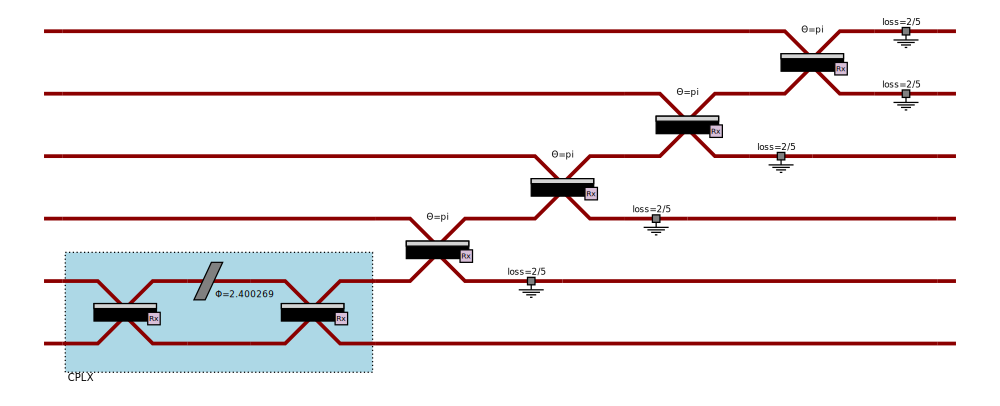

In [23]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_PHOTON_NUMBER = 2
INIT_STATE = [0, 0, 0, 0, 0] + [INIT_PHOTON_NUMBER]
print(f"Init state for new run {INIT_STATE}")
E_PROBABILITY = 0.7
MULTIPHOTON_COMPONENT = 0.1
SCALE = 0.01
BS_INDEX = [3,2,1,0] #+ random_indices_with_repeats(N_MODES-1, 2*(N_MODES-1))
print("Beamsplitter arrangement", BS_INDEX)

# Normalize data
data_renormalized = (data - min(data)) / (max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()

# data_renorm_red = data_renormalized[::10]

# Initialize expectation matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))
parameter_matrix = np.ones(len(BS_INDEX)) * np.pi 

# Main loop for circuit construction and simulation
for i in tqdm(range(len(data_renormalized)), desc="Computing layer"):
    processor = pcvl.Processor("SLOS", len(INIT_STATE))
    # Add circuit beam splitters and connector to ancilla
    # processor.add(N_MODES, pcvl.BS(theta=2 * np.pi * data_renormalized[i]))
    # angle = 2 * np.arccos(np.sqrt(data_renrmalized[i]))
    angle = data_renormalized[i]*2*np.pi
    print(f"Angle {angle}")
    # angle = 0
    processor.add(N_MODES-1, pcvl.BS().add(0, pcvl.PS(phi=angle)).add(0, pcvl.BS()))
    print(f"Prob for upper {np.cos(angle/2)**2}")
    # add BS cascade to ensure full connectivity and add random BS
    for j, index in enumerate(BS_INDEX):
        processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))
    # add loss channel to each mode
    for k in range(N_MODES):
        processor.add(k, pcvl.LC(0.4))

    # parameter_matrix = np.random.normal(loc=data_renormalized[i], scale=SCALE, size=len(BS_INDEX)) * 2 * np.pi
    set_processor_parameters(processor, parameter_matrix)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']
    # prob_distribution = filter_keys_with_sum_one(prob_distribution)

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i,:] = expectations
    # print(f"Expectations {expectations}")
    print(f"Most probable state: {max(prob_distribution, key=prob_distribution.get)}")
    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [INIT_PHOTON_NUMBER]
    print(f"Init state for new run {INIT_STATE}")

# Display the final circuit
print("Expectation matrix shape", expectation_matrix.shape)
print("Final circuit")
pcvl.pdisplay(processor, recursive=True)

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Load a sample dataset
X = expectation_matrix[:-1]
y = data[1:]
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, shuffle=False)
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

# Using RidgeCV for Ridge Regression with built-in cross-validation
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-4, -4, 500), cv=10))
ridge = make_pipeline(Ridge(alpha=2))

# Train the model
ridge.fit(X_train, y_train)

# Extract the best alpha and model's coefficients
# best_alpha_cv = ridge.named_steps['ridgecv'].alpha_
# coefficients = ridge.named_steps['ridgecv'].coef_

# Evaluate the model
y_pred_cv = ridge.predict(X_test)
test_mse_cv = mean_squared_error(y_test, y_pred_cv)

# best_alpha_cv, test_mse_cv, coefficients

X_train shape (339, 5)
y_train shape (339,)
X_test shape (60, 5)
y_test shape (60,)


In [42]:
poly = PolynomialFeatures(degree=10)
expectations_matrix_quad = poly.fit_transform(X_train)
reg_ridge = Ridge(alpha=4).fit(expectations_matrix_quad, y_train)
test_expectation_matrix_quad = poly.fit_transform(X_test)
# Make predictions using the quadratic model
predicted_data_quad = reg_ridge.predict(test_expectation_matrix_quad)

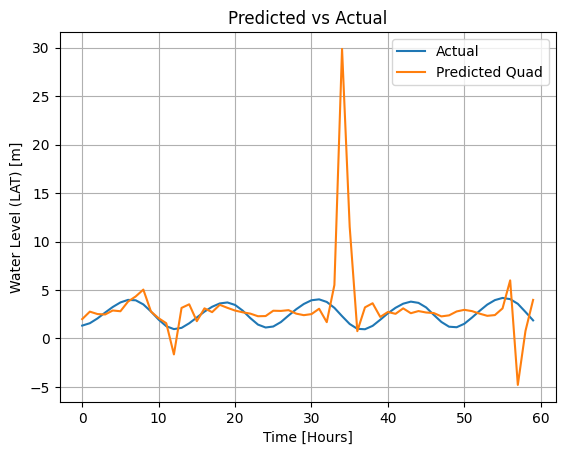

In [44]:
# plt.plot(y_pred_cv, label="Predicted")
plt.plot(y_test[:], label="Actual")
plt.plot(predicted_data_quad[:], label="Predicted Quad")
plt.title('Predicted vs Actual')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)

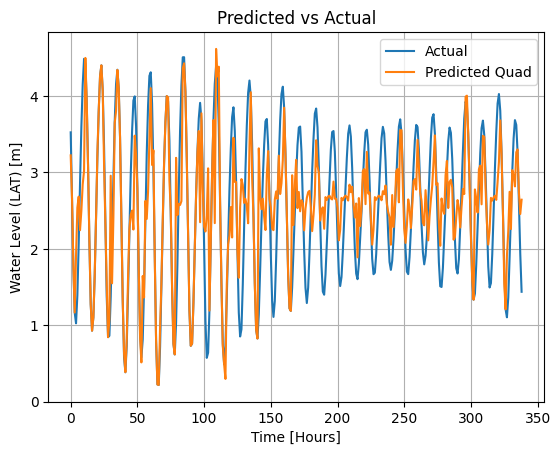

In [37]:
y_pred_train = ridge.predict(X_train)
predicted_data_quad_train = reg_ridge.predict(expectations_matrix_quad)
# plt.plot(y_pred_train, label="Predicted")
plt.plot(y_train, label="Actual")
plt.plot(predicted_data_quad_train, label="Predicted Quad")
plt.title('Predicted vs Actual')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)


In [ ]:
source = pcvl.Source(emission_probability=0.7, multiphoton_component=0.1)
p = pcvl.Processor("SLOS", circuit, source)
p.with_input(pcvl.BasicState(init_state))
sampler = pcvl.algorithm.Sampler(p)
prob_dist = sampler.probs()['results']
prob_dist

BSDistribution(float,
               {|6,0,0,0,0,0,0>: 2.2982747422621365e-08,
                |5,1,0,0,0,0,0>: 2.6687417122952925e-07,
                |5,0,1,0,0,0,0>: 6.25270150499199e-07,
                |5,0,0,1,0,0,0>: 1.6572766784154843e-08,
                |5,0,0,0,1,0,0>: 7.635300728185233e-07,
                |5,0,0,0,0,1,0>: 2.5548340983691925e-07,
                |5,0,0,0,0,0,1>: 2.52849804076078e-06,
                |4,2,0,0,0,0,0>: 1.0302113375064116e-06,
                |4,1,1,0,0,0,0>: 5.318643678167257e-06,
                |4,1,0,1,0,0,0>: 6.391114087469414e-07,
                |4,1,0,0,1,0,0>: 6.0170481911102855e-06,
                |4,1,0,0,0,1,0>: 2.080562375638744e-06,
                |4,1,0,0,0,0,1>: 1.73278051408717e-05,
                |4,0,2,0,0,0,0>: 6.303765557180993e-06,
                |4,0,1,1,0,0,0>: 1.6555786136614882e-06,
                |4,0,1,0,1,0,0>: 1.43735562540988e-05,
                |4,0,1,0,0,1,0>: 5.129749935020066e-06,
                |4,0,1,